<a href="https://colab.research.google.com/github/forexms78/AI-05-/blob/main/%EB%AF%B8%EC%85%986_7%ED%8C%80_%EB%B0%95%EB%B3%91%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from urllib.request import urlretrieve; urlretrieve("https://raw.githubusercontent.com/c0z0c/jupyter_hangul/refs/heads/beta/helper_c0z0c_dev.py", "helper_c0z0c_dev.py")
import helper_c0z0c_dev as helper

🌐 https://c0z0c.github.io/jupyter_hangul
ℹ️ NumPy 2.0.2 (v2.x+): 호환성 모드 적용됨
install fonts-nanum...
Mounted at /content/drive
✅ 설정 완료: 한글 폰트, plt 전역 등록, pandas 확장, 캐시 기능
pd commit 저장 경로 = /content/drive/MyDrive


In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bellboy1","key":"936ffa8a7fc031acd1ab553ee5fc9cec"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
DATASET_ID = 'paultimothymooney/chest-xray-pneumonia'
!kaggle datasets download -d $DATASET_ID

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.24G/2.29G [00:01<00:00, 1.47GB/s]
100% 2.29G/2.29G [00:01<00:00, 1.56GB/s]


In [8]:
ZIP_FILE_NAME = 'chest-xray-pneumonia.zip'
TARGET_DIR = 'chest_xray_data'

In [9]:
!mkdir -p $TARGET_DIR
!unzip -q $ZIP_FILE_NAME -d $TARGET_DIR
!rm $ZIP_FILE_NAME
!ls $TARGET_DIR/chest_xray

파일 압축을 해제
데이터 폴더
chest_xray  __MACOSX  test  train  val


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import random
import cv2

In [11]:
BASE_DIR = 'chest_xray_data/chest_xray'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
VAL_DIR = os.path.join(BASE_DIR, 'val')

IMG_SIZE = 224
BATCH_SIZE = 32

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# 정규화 진행

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

In [14]:
# train 데이터 전처리 및 증강

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

# test, val 데이터 전처리

test_val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)
])

In [15]:
# 파이토치 데이터셋 생성

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_dataset =  datasets.ImageFolder(TEST_DIR, transform=test_val_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=test_val_transforms)

In [16]:
# val 데이터가 적음으로 train test데이터랑 섞기

full_test_dataset = torch.utils.data.ConcatDataset([test_dataset, val_dataset])

In [17]:
# 데이터 셋 크기확인

print(f'train : {len(train_dataset)}')
print(f'test : {len(full_test_dataset)}')
print(f'class : {test_dataset.class_to_idx}')

train : 5216
test : 640
class : {'NORMAL': 0, 'PNEUMONIA': 1}


In [18]:
# 데이터 로더 생성

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)


test_loader = DataLoader(
    full_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

In [19]:
# 데이터 불균형이 있는 데이터이기때문에 이미지 갯수를 파악

pneumonia_count = sum(train_dataset.targets)

total_count = len(train_dataset)
normal_count = total_count - pneumonia_count

print(f'정상 이미지 : {normal_count}개')
print(f'폐렴 이미지 : {pneumonia_count}개')

class_labels = train_dataset.classes
class_counts = [normal_count, pneumonia_count]
df_counts = pd.DataFrame({'Class': class_labels, 'Count': class_counts})

정상 이미지 : 1341개
폐렴 이미지 : 3875개


In [20]:
dataset_path = BASE_DIR


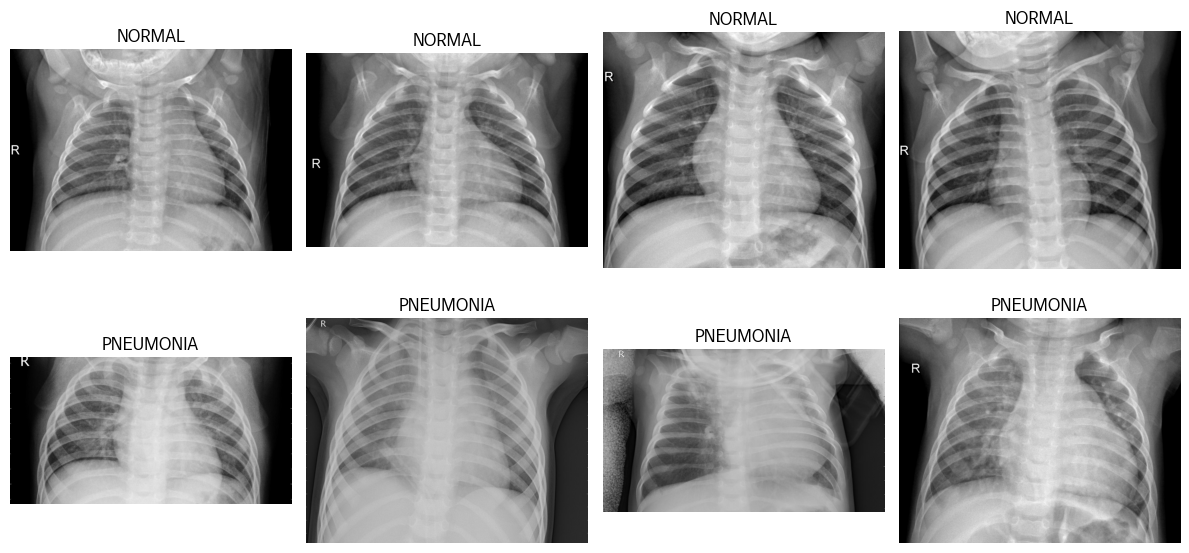

In [24]:
# 이미지확인

def show_samples(category="train"):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i, label in enumerate(["NORMAL", "PNEUMONIA"]):
        img_dir = os.path.join(dataset_path, category, label)

        sample_files = random.sample(os.listdir(img_dir), 4)

        for j, file in enumerate(sample_files):
            img_path = os.path.join(img_dir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].set_title(f"{label}")
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()

show_samples("train")

In [25]:
# @title Custom CNN 모델정의

import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = (F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = (F.relu(self.bn4(self.conv4(x))))

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [45]:
# @title 학습 함수 정의
from tqdm import tqdm
from sklearn.metrics import classification_report
import torch.optim as optim

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    model.to(device)
    running_loss = 0.
    correct = 0.
    total = 0.

    for inputs, labels in tqdm(dataloader, leave=False, desc="Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += (loss.item() * inputs.size(0))
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def elvauation_model(model, dataloader, criterion, device, Test_mode=False):
    model.eval()
    running_loss = 0.
    correct = 0.
    total = 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False, desc="Val"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += (loss.item() * inputs.size(0))

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc = correct / total

    if Test_mode:
        class_names = ["Normal", "Pneumonia"]
        report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
        print(f"\nFinal Test Accuracy: {val_acc:.4f}")
        print(report)

    return val_loss, val_acc

def train_model(num_epochs, model, loss_fn, opt, train_loader, val_loader, device, title, g_path='.', force_save=False):
    train_losses =[]
    train_accs =[]
    val_losses =[]
    val_accs =[]
    old_loss = 100

    for epoch in range(num_epochs):
        print(f"\n[Epoch {epoch+1}/{num_epochs}]")

        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, opt, device)
        val_loss, val_acc = elvauation_model(model, val_loader, loss_fn, device)

        print(f"Train Loss: {train_loss:.4f} / Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} / Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if force_save or old_loss > train_loss:
            save_path = os.path.join(g_path, f"{model.__class__.__name__}_{title}_best.pth")
            torch.save(model.state_dict(), save_path)
            old_loss = train_loss

    return train_losses, train_accs, val_losses, val_accs

In [27]:
# @title 학습 준비 설정 (가중치 손실 함수 적용)

normal_count = 1341
pneumonia_count = 3875
total_count = normal_count + pneumonia_count

weight_normal = total_count / normal_count
weight_pneumonia = total_count / pneumonia_count

# 가중치 텐서 생성
class_weights = torch.tensor([weight_normal, weight_pneumonia],
                             dtype=torch.float32).to(DEVICE)

print(f"클래스 가중치: {class_weights.tolist()}")

num_classes = len(class_labels)

model_basic = CustomCNN(num_classes).to(DEVICE)
# 가중치가 적용된 손실 함수 정의
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
opt = optim.Adam(model_basic.parameters(), lr=0.001)

클래스 가중치: [3.889634609222412, 1.346064567565918]


In [28]:
# @title 기본 모델 학습 실행

num_epochs = 10
train_losses, train_accs, val_losses, val_accs = train_model(num_epochs,
                                                             model_basic,
                                                             loss_fn,
                                                             opt,
                                                             train_loader,
                                                             test_loader,
                                                             DEVICE,
                                                             title="basic_weighted")

print("모델 학습완료")


[Epoch 1/10]


Train Loss: 0.3722 / Acc: 0.8426
Val   Loss: 0.9742 / Acc: 0.5281

[Epoch 2/10]


Train Loss: 0.3005 / Acc: 0.8717
Val   Loss: 0.4785 / Acc: 0.7984

[Epoch 3/10]


Train Loss: 0.2863 / Acc: 0.8786
Val   Loss: 0.5614 / Acc: 0.7641

[Epoch 4/10]


Train Loss: 0.2695 / Acc: 0.8901
Val   Loss: 1.4517 / Acc: 0.5062

[Epoch 5/10]


Train Loss: 0.2425 / Acc: 0.9036
Val   Loss: 0.8503 / Acc: 0.6422

[Epoch 6/10]


Train Loss: 0.2385 / Acc: 0.8988
Val   Loss: 0.4606 / Acc: 0.8375

[Epoch 7/10]


Train Loss: 0.2386 / Acc: 0.9039
Val   Loss: 0.4521 / Acc: 0.8234

[Epoch 8/10]


Train Loss: 0.2138 / Acc: 0.9168
Val   Loss: 0.7455 / Acc: 0.7594

[Epoch 9/10]


Train Loss: 0.1983 / Acc: 0.9237
Val   Loss: 0.6298 / Acc: 0.8031

[Epoch 10/10]


Train Loss: 0.1891 / Acc: 0.9248
Val   Loss: 0.4247 / Acc: 0.8297
모델 학습완료


In [32]:
def plot_history(train_losses, train_accs, val_losses, val_accs, title):

    plt.figure(figsize=(15, 6))

    num_epochs = len(train_losses)
    epochs = range(num_epochs)

    plt.subplot(1, 2, 1)

    sns.lineplot(x=epochs, y=train_losses, label='Train Loss', color='darkblue', linewidth=2)
    sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', color='darkgreen', linewidth=2)

    plt.title(f'{title} - Training and Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)

    sns.lineplot(x=epochs, y=train_accs, label='Train Accuracy', color='darkred', linewidth=2)
    sns.lineplot(x=epochs, y=val_accs, label='Validation Accuracy', color='darkviolet', linewidth=2)

    plt.title(f'{title} - Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

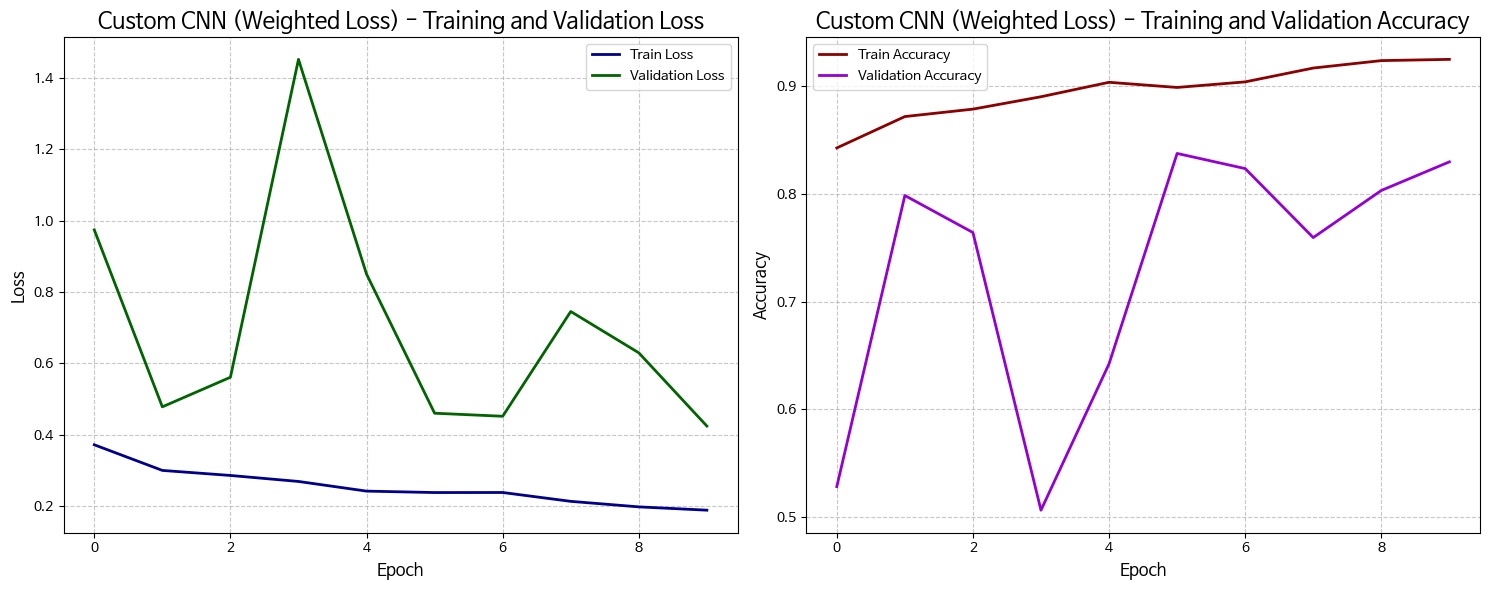

In [33]:
# @title 기본 모델 학습 결과 시각화 실행

plot_history(train_losses, train_accs, val_losses, val_accs, title='Custom CNN (Weighted Loss)')

그래프로 보아
loss는 잘 감소하였으나 train 과 val 차이가 너무 크게 나타났습니다
train acc는 매우 높지만 val acc는 불규칙합니다
 과적합을 피할 수 없을거 같습니다
모델 성능을 개선해보겠습니다

In [35]:
# @title 전이 학습 모델 로드 (ResNet-18)


model_tl = models.resnet18(weights='IMAGENET1K_V1')

for param in model_tl.parameters():
    param.requires_grad = False

num_ftrs = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_ftrs, 2)

model_tl = model_tl.to(DEVICE)
print(f"고정계층 수: {sum(p.requires_grad == False for p in model_tl.parameters())}개")
print(f"학습계층 수: {sum(p.requires_grad == True for p in model_tl.parameters())}개")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]

고정계층 수: 60개
학습계층 수: 2개


In [36]:
# @title 전이 학습 모델 학습 준비

opt_tl = optim.Adam(model_tl.parameters(), lr=0.0001)
loss_fn_tl = nn.CrossEntropyLoss(weight=class_weights)

In [37]:
# @title 전이 학습 모델 학습 실행

num_epochs = 10

tl_train_losses, tl_train_accs, tl_val_losses, tl_val_accs = train_model(num_epochs,
                                                                         model_tl,
                                                                         loss_fn_tl,
                                                                         opt_tl,
                                                                         train_loader,
                                                                         test_loader,
                                                                         DEVICE,
                                                                         title="ResNet18_weighted")



[Epoch 1/10]


Train Loss: 0.5785 / Acc: 0.7237
Val   Loss: 0.4792 / Acc: 0.8000

[Epoch 2/10]


Train Loss: 0.3998 / Acc: 0.8689
Val   Loss: 0.3763 / Acc: 0.8688

[Epoch 3/10]


Train Loss: 0.3253 / Acc: 0.8932
Val   Loss: 0.3430 / Acc: 0.8719

[Epoch 4/10]


Train Loss: 0.2888 / Acc: 0.9039
Val   Loss: 0.3206 / Acc: 0.8766

[Epoch 5/10]


Train Loss: 0.2638 / Acc: 0.9086
Val   Loss: 0.2991 / Acc: 0.8922

[Epoch 6/10]


Train Loss: 0.2457 / Acc: 0.9172
Val   Loss: 0.2841 / Acc: 0.8875

[Epoch 7/10]


Train Loss: 0.2374 / Acc: 0.9156
Val   Loss: 0.2810 / Acc: 0.8828

[Epoch 8/10]


Train Loss: 0.2286 / Acc: 0.9189
Val   Loss: 0.2814 / Acc: 0.8859

[Epoch 9/10]


Train Loss: 0.2168 / Acc: 0.9233
Val   Loss: 0.2595 / Acc: 0.8938

[Epoch 10/10]


Train Loss: 0.2105 / Acc: 0.9239
Val   Loss: 0.2574 / Acc: 0.8922


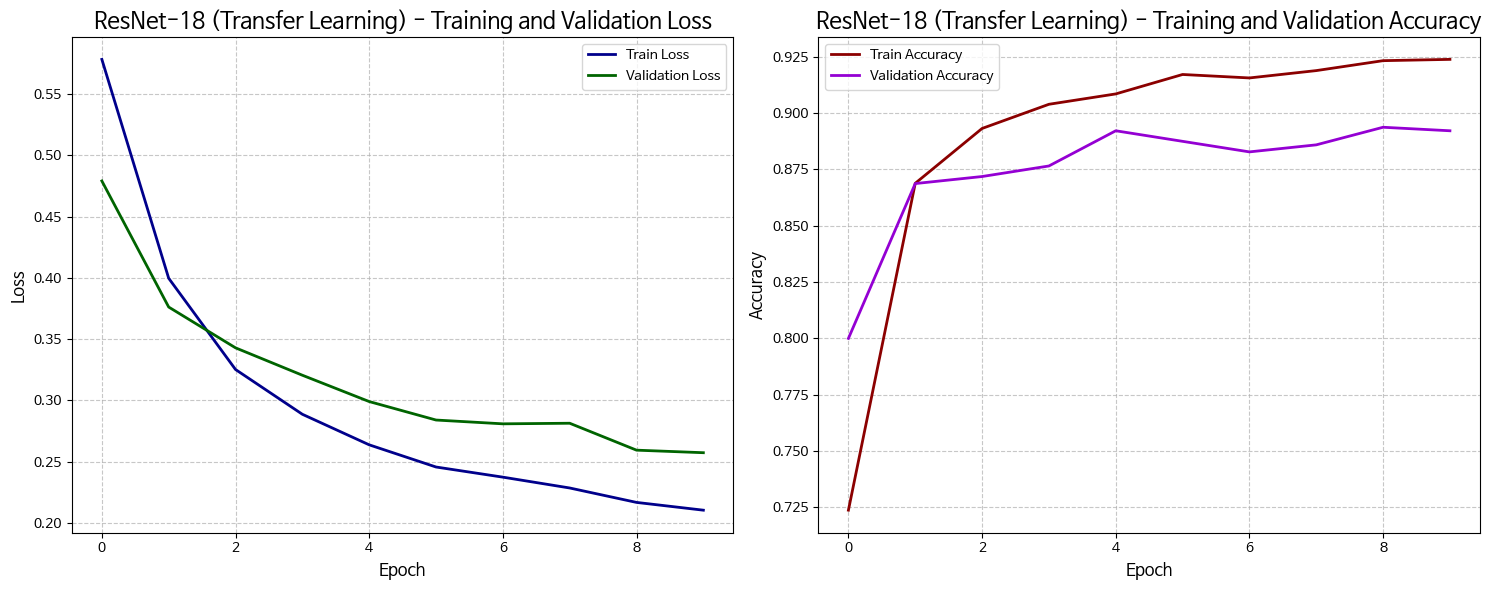

In [38]:
# @title ResNet-18 전이 학습 결과 시각화 실행

plot_history(tl_train_losses, tl_train_accs, tl_val_losses, tl_val_accs, title='ResNet-18 (Transfer Learning)')

두 loss값 차이가 훨씬 줄어들었습니다
acc도 안정적이게 고성능에 달성했습니다

과적합도 개선이 된거같고 성능도 올라갔습니다

In [48]:
# @title 현재 디렉토리 파일 목록 확인

!ls

chest_xray_data      kaggle.json			sample_data
drive		     __pycache__
helper_c0z0c_dev.py  ResNet_ResNet18_weighted_best.pth


In [46]:
# @title 전이 학습 모델 재실행 (가중치 파일 생성)
num_epochs = 1

tl_train_losses, tl_train_accs, tl_val_losses, tl_val_accs = train_model(num_epochs,
                                                                         model_tl,
                                                                         loss_fn_tl,
                                                                         opt_tl,
                                                                         train_loader,
                                                                         test_loader,
                                                                         DEVICE,
                                                                         title="ResNet18_weighted")


[Epoch 1/1]


Train Loss: 0.2063 / Acc: 0.9235
Val   Loss: 0.2558 / Acc: 0.8953


In [49]:
# @title 테스트 모델 로드 및 평가 준비

best_model_path = "ResNet_ResNet18_weighted_best.pth"

final_model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = final_model.fc.in_features
final_model.fc = nn.Linear(num_ftrs, 2)
final_model = final_model.to(DEVICE)

final_model.load_state_dict(torch.load(best_model_path))
test_loss, test_acc = elvauation_model(final_model,
                                       test_loader,
                                       loss_fn_tl,
                                       DEVICE,
                                       Test_mode=True)


Final Test Accuracy: 0.8953
              precision    recall  f1-score   support

      Normal     0.8631    0.8595    0.8613       242
   Pneumonia     0.9148    0.9171    0.9159       398

    accuracy                         0.8953       640
   macro avg     0.8889    0.8883    0.8886       640
weighted avg     0.8952    0.8953    0.8953       640



In [53]:
# @title Full Fine-Tuning 모델 정의 (ResNet-18)


model_full_ft = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model_full_ft.fc.in_features
model_full_ft.fc = nn.Linear(num_ftrs, 2)

model_full_ft = model_full_ft.to(DEVICE)

print(f"학습 가능한 계층 수: {sum(p.requires_grad == True for p in model_full_ft.parameters())}개")

학습 가능한 계층 수: 62개


In [54]:
# @title Full Fine-Tuning 학습 준비 (Learning Rate = 0.00001)

opt_full_ft = optim.Adam(model_full_ft.parameters(), lr=0.00001)
loss_fn_full_ft = nn.CrossEntropyLoss(weight=class_weights)

In [56]:
# @title Full Fine-Tuning 모델 학습 실행

num_epochs = 10

full_ft_train_losses, full_ft_train_accs, full_ft_val_losses, full_ft_val_accs = train_model(
    num_epochs,
    model_full_ft,
    loss_fn_full_ft,
    opt_full_ft,
    train_loader,
    test_loader,
    DEVICE,
    title="ResNet18_Full_FT")


[Epoch 1/10]


Train Loss: 0.3283 / Acc: 0.7891
Val   Loss: 0.2504 / Acc: 0.9156

[Epoch 2/10]


Train Loss: 0.1301 / Acc: 0.9549
Val   Loss: 0.3252 / Acc: 0.8703

[Epoch 3/10]


Train Loss: 0.0875 / Acc: 0.9726
Val   Loss: 0.3712 / Acc: 0.8641

[Epoch 4/10]


Train Loss: 0.0694 / Acc: 0.9783
Val   Loss: 0.3478 / Acc: 0.8766

[Epoch 5/10]


Train Loss: 0.0609 / Acc: 0.9774
Val   Loss: 0.4769 / Acc: 0.8359

[Epoch 6/10]


Train Loss: 0.0558 / Acc: 0.9831
Val   Loss: 0.4797 / Acc: 0.8375

[Epoch 7/10]


Train Loss: 0.0496 / Acc: 0.9833
Val   Loss: 0.5543 / Acc: 0.8219

[Epoch 8/10]


Train Loss: 0.0424 / Acc: 0.9864
Val   Loss: 0.5854 / Acc: 0.8266

[Epoch 9/10]


Train Loss: 0.0390 / Acc: 0.9866
Val   Loss: 0.5402 / Acc: 0.8344

[Epoch 10/10]


Train Loss: 0.0400 / Acc: 0.9879
Val   Loss: 0.6287 / Acc: 0.8250


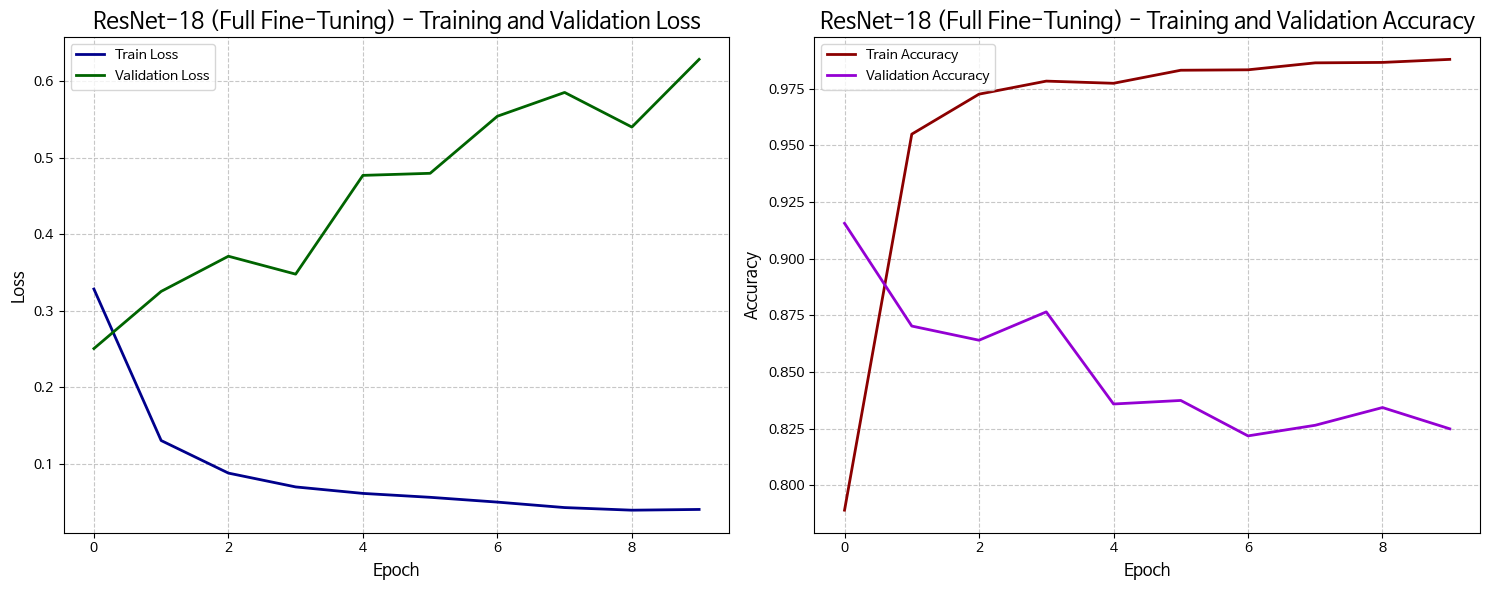

In [60]:
# @title Full Fine-Tuning 모델 학습 결과 시각화 실행

plot_history(full_ft_train_losses, full_ft_train_accs, full_ft_val_losses, full_ft_val_accs, title='ResNet-18 (Full Fine-Tuning)')